# 01 - Exploratory Data Analysis (EDA)

This notebook performs initial exploration of the HandFlow gesture dataset.

## Objectives
1. Understand dataset structure and size
2. Analyze class distribution (gesture balance)
3. Visualize keypoint distributions
4. Identify potential data quality issues
5. Generate summary statistics

In [1]:
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Imports loaded")

✅ Imports loaded


## 1. Dataset Overview

In [4]:
# Configuration
DATA_PATH = Path('../data/raw/right_mp_data')  # Right hand data
LEFT_DATA_PATH = Path('../data/raw/Left_MP_Data')  # Left hand data (if exists)
SEQUENCE_LENGTH = 16  # Frames per sequence

# Check if data exists
if not DATA_PATH.exists():
    # Try ModelTraining path (original location)
    DATA_PATH = Path('../ModelTraining/MP_Data')
    LEFT_DATA_PATH = Path('../ModelTraining/Left_MP_Data')

print(f"📁 Data path: {DATA_PATH}")
print(f"📁 Data exists: {DATA_PATH.exists()}")

📁 Data path: ../data/raw/right_mp_data
📁 Data exists: True


In [5]:
# Define gesture classes
RIGHT_ACTIONS = ['none', 'nonezoom', 'swiperight', 'zoom', 'pointyclick', 'middleclick', 'ringclick', 'pinkyclick']
LEFT_ACTIONS = ['none', 'nonezoom', 'swipeleft', 'zoom', 'pointyclick', 'middleclick', 'ringclick', 'pinkyclick']

print(f"📊 Right hand gestures: {len(RIGHT_ACTIONS)}")
print(f"📊 Left hand gestures: {len(LEFT_ACTIONS)}")

📊 Right hand gestures: 8
📊 Left hand gestures: 8


In [6]:
def count_sequences(data_path, actions):
    """
    Count sequences per action class.
    
    Returns:
        dict: {action_name: sequence_count}
    """
    counts = {}
    
    for action in actions:
        action_path = data_path / action
        if action_path.exists():
            # Count sequence folders
            seq_dirs = [d for d in action_path.iterdir() if d.is_dir()]
            counts[action] = len(seq_dirs)
        else:
            counts[action] = 0
            
    return counts

# Count sequences
right_counts = count_sequences(DATA_PATH, RIGHT_ACTIONS)

# Display as DataFrame
df_counts = pd.DataFrame({
    'Gesture': list(right_counts.keys()),
    'Sequences': list(right_counts.values())
})
df_counts['Percentage'] = (df_counts['Sequences'] / df_counts['Sequences'].sum() * 100).round(2)

print("\n📊 Dataset Summary:")
print(f"   Total sequences: {df_counts['Sequences'].sum()}")
print(f"   Total frames: {df_counts['Sequences'].sum() * SEQUENCE_LENGTH}")
print("\n")
df_counts


📊 Dataset Summary:
   Total sequences: 300
   Total frames: 4800




,Gesture,Sequences,Percentage
0,none,60,20.0
1,nonezoom,0,0.0
2,swiperight,60,20.0
3,zoom,60,20.0
4,pointyclick,60,20.0
5,middleclick,60,20.0
6,ringclick,0,0.0
7,pinkyclick,0,0.0


## 2. Class Distribution Analysis

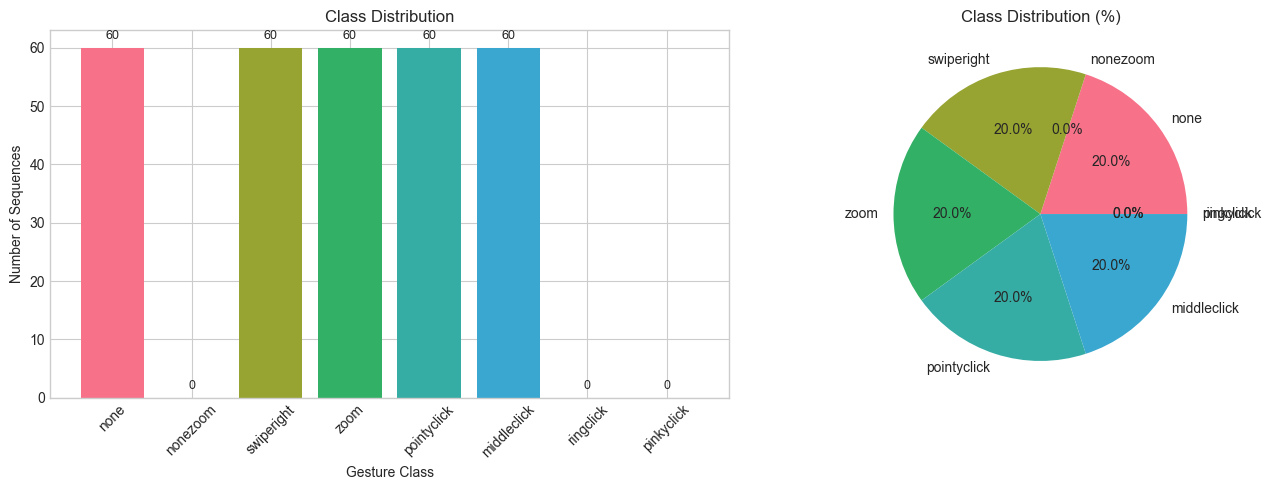


⚖️ Class Imbalance Analysis:
   Max samples: 60 (none)
   Min samples: 60
   Imbalance ratio: 1.00x


In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette('husl', len(df_counts))
axes[0].bar(df_counts['Gesture'], df_counts['Sequences'], color=colors)
axes[0].set_xlabel('Gesture Class')
axes[0].set_ylabel('Number of Sequences')
axes[0].set_title('Class Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels
for i, (gesture, count) in enumerate(zip(df_counts['Gesture'], df_counts['Sequences'])):
    axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(df_counts['Sequences'], labels=df_counts['Gesture'], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Class Distribution (%)')

plt.tight_layout()
plt.savefig('../docs/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for class imbalance
max_count = df_counts['Sequences'].max()
min_count = df_counts[df_counts['Sequences'] > 0]['Sequences'].min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n⚖️ Class Imbalance Analysis:")
print(f"   Max samples: {max_count} ({df_counts.loc[df_counts['Sequences'].idxmax(), 'Gesture']})")
print(f"   Min samples: {min_count}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 3:
    print("   ⚠️ Significant class imbalance detected! Consider:")
    print("      - Collecting more data for minority classes")
    print("      - Using class weights during training")
    print("      - Data augmentation")

## 3. Keypoint Data Analysis

In [8]:
def load_sample_data(data_path, actions, max_sequences_per_class=10):
    """
    Load sample data for analysis.
    
    Returns:
        all_data: np.array of shape (n_samples, seq_len, 84)
        labels: list of action names
    """
    all_sequences = []
    all_labels = []
    
    for action in actions:
        action_path = data_path / action
        if not action_path.exists():
            continue
            
        seq_dirs = sorted([d for d in action_path.iterdir() if d.is_dir()])[:max_sequences_per_class]
        
        for seq_dir in seq_dirs:
            frames = []
            for frame_num in range(16):
                frame_path = seq_dir / f"{frame_num}.npy"
                if frame_path.exists():
                    frames.append(np.load(frame_path))
            
            if len(frames) == 16:
                all_sequences.append(np.array(frames))
                all_labels.append(action)
    
    return np.array(all_sequences), all_labels

# Load sample data
print("📥 Loading sample data...")
sample_data, sample_labels = load_sample_data(DATA_PATH, RIGHT_ACTIONS, max_sequences_per_class=20)
print(f"   Loaded shape: {sample_data.shape}")
print(f"   Labels: {len(sample_labels)}")

📥 Loading sample data...
   Loaded shape: (100, 16, 84)
   Labels: 100


In [9]:
# Keypoint statistics
print("📊 Keypoint Statistics:")
print(f"   Shape per sequence: {sample_data.shape[1:]}")
print(f"   Features per frame: {sample_data.shape[2]}")
print(f"   (21 landmarks × 4 values = 84)")
print()
print(f"   Min value: {sample_data.min():.4f}")
print(f"   Max value: {sample_data.max():.4f}")
print(f"   Mean: {sample_data.mean():.4f}")
print(f"   Std: {sample_data.std():.4f}")

# Check for NaN or Inf
nan_count = np.isnan(sample_data).sum()
inf_count = np.isinf(sample_data).sum()
print()
print(f"   NaN values: {nan_count}")
print(f"   Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("   ⚠️ Data quality issue detected!")

📊 Keypoint Statistics:
   Shape per sequence: (16, 84)
   Features per frame: 84
   (21 landmarks × 4 values = 84)

   Min value: 0.0000
   Max value: 0.0000
   Mean: 0.0000
   Std: 0.0000

   NaN values: 0
   Inf values: 0


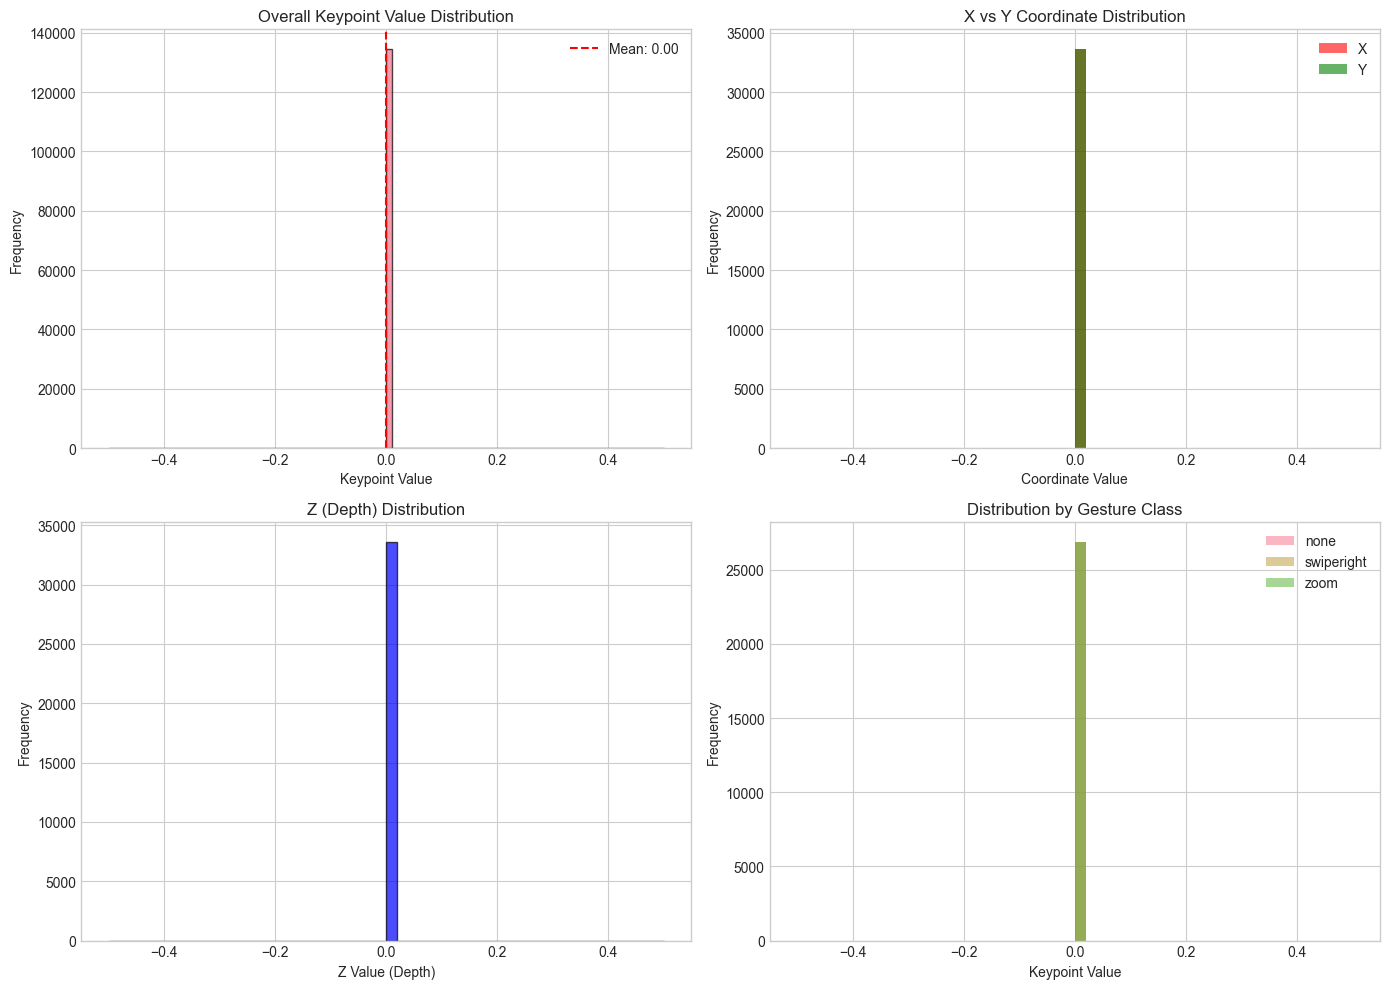

In [10]:
# Visualize keypoint value distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten all data for distribution
flat_data = sample_data.flatten()

# Overall distribution
axes[0, 0].hist(flat_data, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Keypoint Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall Keypoint Value Distribution')
axes[0, 0].axvline(flat_data.mean(), color='red', linestyle='--', label=f'Mean: {flat_data.mean():.2f}')
axes[0, 0].legend()

# X, Y, Z distributions (columns 0, 1, 2 for each landmark)
x_values = sample_data[:, :, 0::4].flatten()  # Every 4th starting from 0
y_values = sample_data[:, :, 1::4].flatten()  # Every 4th starting from 1
z_values = sample_data[:, :, 2::4].flatten()  # Every 4th starting from 2

axes[0, 1].hist(x_values, bins=50, alpha=0.6, label='X', color='red')
axes[0, 1].hist(y_values, bins=50, alpha=0.6, label='Y', color='green')
axes[0, 1].set_xlabel('Coordinate Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('X vs Y Coordinate Distribution')
axes[0, 1].legend()

# Z distribution (depth)
axes[1, 0].hist(z_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Z Value (Depth)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Z (Depth) Distribution')

# Distribution by gesture class
for action in RIGHT_ACTIONS[:4]:  # First 4 gestures
    mask = [l == action for l in sample_labels]
    if sum(mask) > 0:
        class_data = sample_data[mask].flatten()
        axes[1, 1].hist(class_data, bins=50, alpha=0.5, label=action)

axes[1, 1].set_xlabel('Keypoint Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution by Gesture Class')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../docs/keypoint_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Temporal Analysis

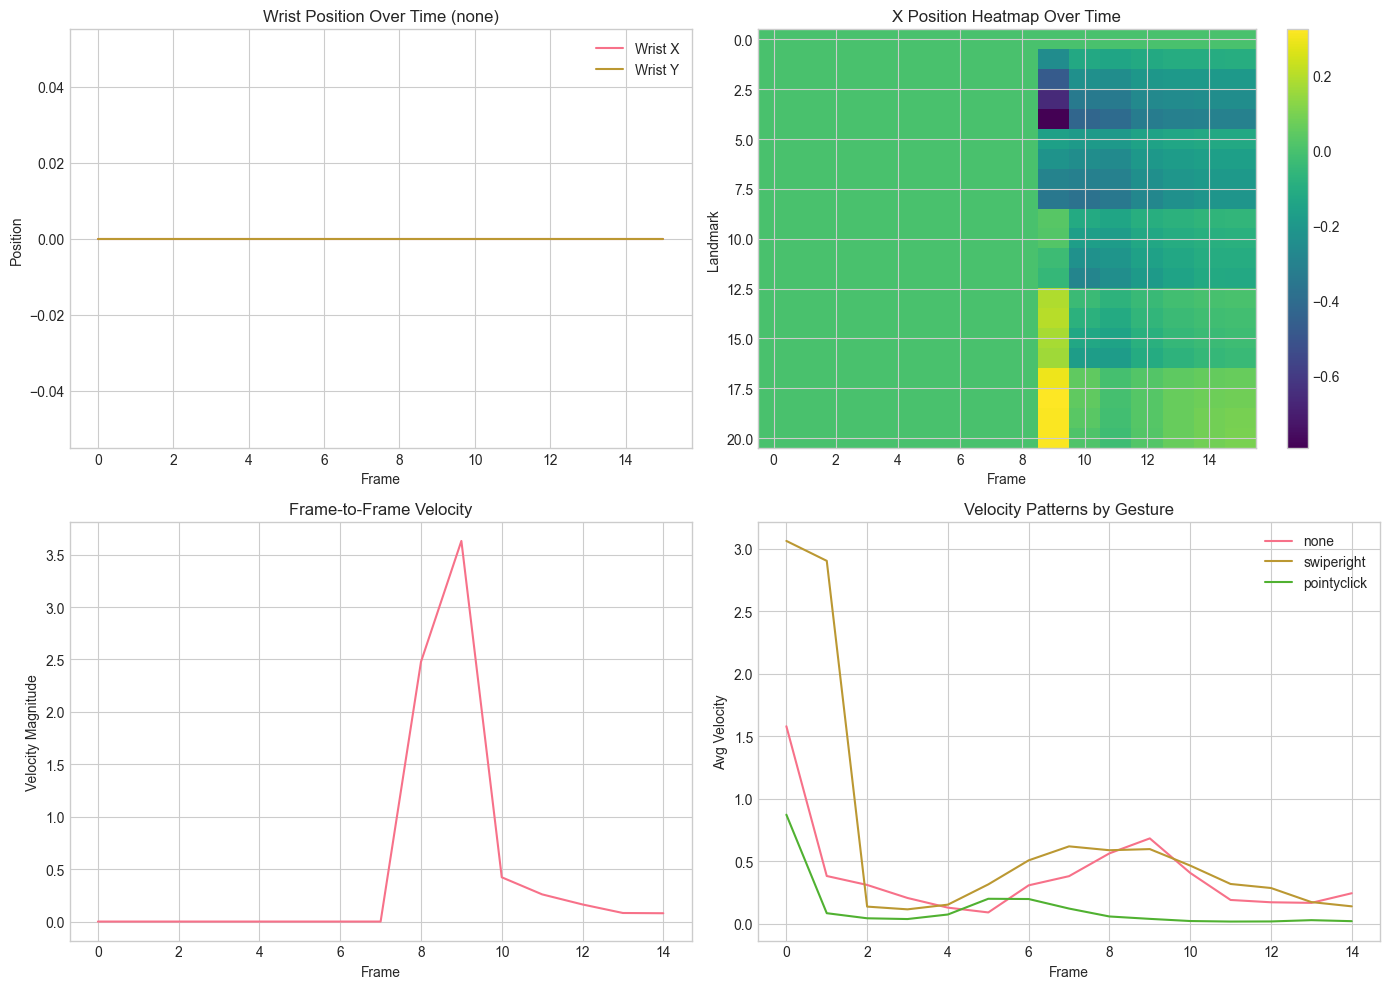

In [9]:
# Analyze temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pick a sample sequence for visualization
sample_idx = 0
sample_seq = sample_data[sample_idx]

# Plot hand movement over time (wrist position - landmark 0)
wrist_x = sample_seq[:, 0]  # x of wrist
wrist_y = sample_seq[:, 1]  # y of wrist

axes[0, 0].plot(wrist_x, label='Wrist X')
axes[0, 0].plot(wrist_y, label='Wrist Y')
axes[0, 0].set_xlabel('Frame')
axes[0, 0].set_ylabel('Position')
axes[0, 0].set_title(f'Wrist Position Over Time ({sample_labels[sample_idx]})')
axes[0, 0].legend()

# Plot all landmark x positions as heatmap
x_positions = sample_seq[:, 0::4]  # (16 frames, 21 landmarks)
im = axes[0, 1].imshow(x_positions.T, aspect='auto', cmap='viridis')
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Landmark')
axes[0, 1].set_title('X Position Heatmap Over Time')
plt.colorbar(im, ax=axes[0, 1])

# Frame-to-frame velocity
velocity = np.diff(sample_seq, axis=0)
velocity_magnitude = np.linalg.norm(velocity, axis=1)
axes[1, 0].plot(velocity_magnitude)
axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Velocity Magnitude')
axes[1, 0].set_title('Frame-to-Frame Velocity')

# Compare velocity patterns across gestures
for action in ['none', 'swiperight', 'pointyclick']:
    mask = [l == action for l in sample_labels]
    if sum(mask) > 0:
        action_data = sample_data[mask]
        # Average velocity across samples
        velocities = np.diff(action_data, axis=1)
        avg_velocity = np.mean(np.linalg.norm(velocities, axis=2), axis=0)
        axes[1, 1].plot(avg_velocity, label=action)

axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Avg Velocity')
axes[1, 1].set_title('Velocity Patterns by Gesture')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../docs/temporal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary & Recommendations

In [10]:
# Generate summary report
print("="*60)
print("📋 EDA SUMMARY REPORT")
print("="*60)
print()
print("📊 DATASET STATISTICS:")
print(f"   • Total sequences: {df_counts['Sequences'].sum()}")
print(f"   • Total frames: {df_counts['Sequences'].sum() * 16}")
print(f"   • Gesture classes: {len(RIGHT_ACTIONS)}")
print(f"   • Sequence length: 16 frames")
print(f"   • Features per frame: 84 (21 landmarks × 4 values)")
print()
print("⚖️ CLASS BALANCE:")
print(f"   • Imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print(f"   • ⚠️ IMBALANCED - Consider class weights")
else:
    print(f"   • ✅ Reasonably balanced")
print()
print("📈 DATA QUALITY:")
print(f"   • NaN values: {nan_count} {'⚠️' if nan_count > 0 else '✅'}")
print(f"   • Inf values: {inf_count} {'⚠️' if inf_count > 0 else '✅'}")
print(f"   • Value range: [{sample_data.min():.4f}, {sample_data.max():.4f}]")
print()
print("💡 RECOMMENDATIONS:")
print("   1. Data appears normalized (wrist-centered)")
print("   2. Consider adding velocity/acceleration features")
print("   3. Temporal patterns visible - LSTM/GRU should work well")
print("   4. Z-depth variation may help with distance-based gestures")
print("="*60)

📋 EDA SUMMARY REPORT

📊 DATASET STATISTICS:
   • Total sequences: 600
   • Total frames: 9600
   • Gesture classes: 8
   • Sequence length: 16 frames
   • Features per frame: 84 (21 landmarks × 4 values)

⚖️ CLASS BALANCE:
   • Imbalance ratio: 4.00x
   • ⚠️ IMBALANCED - Consider class weights

📈 DATA QUALITY:
   • NaN values: 0 ✅
   • Inf values: 0 ✅
   • Value range: [-0.9973, 0.9099]

💡 RECOMMENDATIONS:
   1. Data appears normalized (wrist-centered)
   2. Consider adding velocity/acceleration features
   3. Temporal patterns visible - LSTM/GRU should work well
   4. Z-depth variation may help with distance-based gestures


## Next Steps

Continue to:
1. **02_data_exploration.ipynb** - Visualize specific gesture sequences
2. **03_feature_engineering.ipynb** - Experiment with velocity, angles, bbox features
3. **04_model_exploration.ipynb** - Compare LSTM, GRU, CNN architectures